In [1]:
import ants
import tifffile
import numpy as np
import os
import cv2
import json
import time
import pandas as pd

from scipy import stats
import gc
from tifffile import TiffFile

import tifffile
from scipy.ndimage import zoom
import traceback
import gzip
import shutil
from scipy.stats import pearsonr

import cfospy
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap, BoundaryNorm, ListedColormap, hsv_to_rgb
from multiprocessing import Pool
plt.gray()
import datetime

import json, os.path, os, re, time
# import joblib
import subprocess as sp
import nibabel as nib
import scipy.spatial
from scipy.signal import convolve

from statsmodels.stats.multitest import multipletests


<Figure size 640x480 with 0 Axes>

In [2]:

import math
def rad2ph(rad):
#     return (int((2*np.pi+rad)*180/np.pi*24/360),  int((rad)*180/np.pi*24/360))[rad>=0]
    if math.isnan(rad):
        return np.nan
    else:
        return (round((2*np.pi+rad)*180/np.pi*24/360, 1),  round((rad)*180/np.pi*24/360, 1))[rad>=0]
    

In [3]:
# cfos_fol="/home/gpu_data/data1/yamashitaData1/231012_circadian_2nd_Data1/231012_circadian_2nd_Reconst/"
# exp = "2nd"
cfos_fol="/home/gpu_data/data1/yamashitaData1/230828circadian_Data1/230828circadian_1st_Reconst/"
exp = "1st"
savedir = "/home/gpu_data/data8/cfos_app/"
figdir = "/home/gpu_data/data8/cfos_app/figure_articles/timetable/"
os.makedirs(figdir, exist_ok=True)

CT_li = np.arange(0,48,4)
sample_ids = np.arange(1,7,1)

reconsts = os.listdir(cfos_fol)
sample_names=[]
colors=[]
data_parent_paths=[]
data_moving_paths =[]

for CT in CT_li:
#     if CT<44:
#         continue
    for sample_id in sample_ids:
#         if sample_id >1:
#             continue
        sample = "CT"+str(CT)+"_"+str(sample_id).zfill(2)

        for reconst in reconsts:
#             sample_names.append(("_").join(reconst.split("_")[1:3]))

            if sample in reconst:
                sample_names.append(sample)
                for color in os.listdir(cfos_fol+reconst):
                    if "cfos" in color:
                        data_moving_paths.append(cfos_fol+reconst+"/"+color)
                    else:
                        data_parent_paths.append(cfos_fol+reconst+"/"+color)

print(len(data_parent_paths))   
print(len(data_moving_paths))
print(len(sample_names))

72
72
72


In [4]:
#load atlas data

import cfospy
vx=50
rdir = "/home/gpu_data/data1/CUBIC_R_atlas_ver5_scn/"

ca=cfospy.analysis.read_atlas_data(rdir, vx)

print(len(ca.ID_all))


uni_IDs,rev_IDs = ca.get_uni_rIDs()

print(len(uni_IDs))
df_sum = ca.get_sum_temp(uni_IDs)
print(df_sum)

# add_mask=True
# atlas_img, atlas_mask = ca.get_atlas_img(add_mask)

# print(ca.x_num)
                        

voxel_num: 36245880
837
region_num: 831
remove IDs: [485, 928, 917, 514, 760]
831
     Unnamed: 0   id    acronym                           node_name  \
2             2  567         CH                            Cerebrum   
3             3  688        CTX                     Cerebral cortex   
4             4  695      CTXpl                      Cortical plate   
5             5  315  Isocortex                           Isocortex   
6             6  184        FRP       Frontal pole, cerebral cortex   
..          ...  ...        ...                                 ...   
834         834  129         V3                     third ventricle   
835         835  140         AQ                   cerebral aqueduct   
836         836  145         V4                    fourth ventricle   
837         837  153        V4r                      lateral recess   
838         838  164          c  central canal, spinal cord/medulla   

     graph_order      rgb_triplet  
2              2  [176, 240, 

In [5]:

figdir = "/home/gpu_data/data8/cfos_app/figure_timetable/"
os.makedirs(figdir, exist_ok=True)
def calc_CT_norm(CT_df, th):
    CTs =np.arange(0, 24*1,4)
    num_samp=6


    CT_mean_li = np.zeros(len(CTs))

#     df_i = CT_df[CT_df["id"].isin(ID_li)]
    
    df_i=CT_df[CT_df["BH.Q"]<th]
    ids = df_i["id"].tolist()

    # if query == "fdr":
    #     df_i = df_i[df_i["BH.Q"] < 0.05]

    print("num of regions:", len(df_i))
#     new_order = [i for i in ID_li if i in df_i["id"].tolist()]

#     df_i=df_i.sort_values(by='id', key=lambda x: x.map({v: i for i, v in enumerate(new_order)}))


    name_li = []
    for rID in df_i["id"]:
        name_li.append(CT_df[CT_df["id"]==rID]["acronym"].iloc[0])
        
    df_all = np.array(df_i.iloc[:,9:])
    
    #minmax
#     df_i = (4*(df_all-np.min(df_all, axis=1).reshape(-1,1))/(np.max(df_all-np.min(df_all, axis=1).reshape(-1,1), axis=1)).reshape(-1,1))-2
    
    #z 
    df_i = (df_all-np.mean(df_all, axis=1).reshape(-1,1))/(np.mean(df_all, axis=1).reshape(-1,1))
    
    
    CT_ms = np.zeros((len(df_i),len(CTs)))
    CT_sds = np.zeros((len(df_i),len(CTs)))
    for CT_i in range(len(CTs)):
#         if CT_i>0:
#             continue
        CT_li = np.array((df_i[:, CT_i*num_samp:(CT_i+1)*num_samp]))
#         print(df_i.iloc[:, CT_i*num_samp+8+6*6:(CT_i+1)*num_samp+8+6*6])
#         print(df_i.iloc[:, CT_i*num_samp+8+6*6*2:(CT_i+1)*num_samp+8+6*6*2])
#         print(df_i.iloc[:, CT_i*num_samp+8+6*6*3:(CT_i+1)*num_samp+8+6*6*3])
        
        CT_li = CT_li + np.array( (df_i[:, CT_i*num_samp+6*6:(CT_i+1)*num_samp+6*6]))
        CT_li = CT_li + np.array((df_i[:, CT_i*num_samp+6*6*2:(CT_i+1)*num_samp+6*6*2]))
        CT_li = CT_li + np.array((df_i[:, CT_i*num_samp+6*6*3:(CT_i+1)*num_samp+6*6*3]))
        CT_li = CT_li/4
        
#         print(CT_li)
        
        CT_ms[:,CT_i] = np.mean(CT_li, axis=1)
        CT_sds[:,CT_i] = np.std(CT_li, axis=1) #  /np.sqrt(num_samp)

#     CT_norm = (CT_ms-np.min(CT_ms, axis=1).reshape(-1,1))/(np.max(CT_ms-np.min(CT_ms, axis=1).reshape(-1,1), axis=1)).reshape(-1,1)
    
#     CT_norm = (4*(CT_ms-np.min(CT_ms, axis=1).reshape(-1,1))/(np.max(CT_ms-np.min(CT_ms, axis=1).reshape(-1,1), axis=1)).reshape(-1,1))-2
    
    
#     (2 * (x - min_val) / (max_val - min_val)) - 1
    #     CT_norm = CT_norm + 0.1/1.1
    
    
#     CT_norm = (CT_ms)/(np.max(CT_ms, axis=1)).reshape(-1,1)
    
    
    return ids, df_i,  CT_ms


def calc_CT_norm_1st(CT_df, th):
    CTs =np.arange(0, 24*1,4)
    num_samp=6


    CT_mean_li = np.zeros(len(CTs))

#     df_i = CT_df[CT_df["id"].isin(ID_li)]
    
    df_i=CT_df[CT_df["BH.Q"]<th]
    ids = df_i["id"].tolist()

    # if query == "fdr":
    #     df_i = df_i[df_i["BH.Q"] < 0.05]

    print("num of regions:", len(df_i))
#     new_order = [i for i in ID_li if i in df_i["id"].tolist()]

#     df_i=df_i.sort_values(by='id', key=lambda x: x.map({v: i for i, v in enumerate(new_order)}))


    name_li = []
    for rID in df_i["id"]:
        name_li.append(CT_df[CT_df["id"]==rID]["acronym"].iloc[0])
        
    df_all = np.array(df_i.iloc[:,9:])
    
    #minmax
#     df_i = (4*(df_all-np.min(df_all, axis=1).reshape(-1,1))/(np.max(df_all-np.min(df_all, axis=1).reshape(-1,1), axis=1)).reshape(-1,1))-2
    
    #z 
    df_i = (df_all-np.mean(df_all, axis=1).reshape(-1,1))/(np.std(df_all, axis=1).reshape(-1,1))
    
    
    CT_ms = np.zeros((len(df_i),len(CTs)))
    CT_sds = np.zeros((len(df_i),len(CTs)))
    for CT_i in range(len(CTs)):
#         if CT_i>0:
#             continue
        CT_li = np.array((df_i[:, CT_i*num_samp:(CT_i+1)*num_samp]))
#         print(df_i.iloc[:, CT_i*num_samp+8+6*6:(CT_i+1)*num_samp+8+6*6])
#         print(df_i.iloc[:, CT_i*num_samp+8+6*6*2:(CT_i+1)*num_samp+8+6*6*2])
#         print(df_i.iloc[:, CT_i*num_samp+8+6*6*3:(CT_i+1)*num_samp+8+6*6*3])
        
        CT_li = CT_li + np.array( (df_i[:, CT_i*num_samp+6*6:(CT_i+1)*num_samp+6*6]))
#         CT_li = CT_li + np.array((df_i[:, CT_i*num_samp+6*6*2:(CT_i+1)*num_samp+6*6*2]))
#         CT_li = CT_li + np.array((df_i[:, CT_i*num_samp+6*6*3:(CT_i+1)*num_samp+6*6*3]))
        CT_li = CT_li/2
        
#         print(CT_li)
        
        CT_ms[:,CT_i] = np.mean(CT_li, axis=1)
        CT_sds[:,CT_i] = np.std(CT_li, axis=1) #  /np.sqrt(num_samp)

#     CT_norm = (CT_ms-np.min(CT_ms, axis=1).reshape(-1,1))/(np.max(CT_ms-np.min(CT_ms, axis=1).reshape(-1,1), axis=1)).reshape(-1,1)
    
#     CT_norm = (4*(CT_ms-np.min(CT_ms, axis=1).reshape(-1,1))/(np.max(CT_ms-np.min(CT_ms, axis=1).reshape(-1,1), axis=1)).reshape(-1,1))-2
    
    
#     (2 * (x - min_val) / (max_val - min_val)) - 1
    #     CT_norm = CT_norm + 0.1/1.1
    
    
#     CT_norm = (CT_ms)/(np.max(CT_ms, axis=1)).reshape(-1,1)
    
    
    return ids, df_i,  CT_ms


def calc_score(sample_names, predicted):
    ans = [int(sample.split("_")[0][2:]) for sample in sample_names]
    ans2 = []
    for a in ans:
        if a>20:
            a=a-24
        ans2.append(a)

    predicted_rp = [i+24 for i in predicted]
    predicted_rm = [i-24 for i in predicted]

    diff = np.zeros((3, len(sample_names)), dtype="float32")
    diff[0] = np.abs(np.array(predicted))
    diff[1] = np.abs(np.array(predicted_rp))
    diff[2] = np.abs(np.array(predicted_rm))
    diff_a = np.abs(diff-np.array(ans2))
    # diff_a.shape

    min_diff = np.min(diff_a, axis = 0)
    score = np.sum(min_diff)
    sortin = np.argmin(diff_a, axis = 0)
    print(score)
    sortin
    predicted_t = []
    for n, s in enumerate(sortin):
        predicted_t.append(diff[s][n])

#     plt.figure(figsize=(10,6))
#     plt.scatter(np.arange(0, len(sample_names)), ans2, s = 5)
#     plt.scatter(np.arange(0, len(sample_names)), predicted_t, s = 6)
#     plt.plot(ans2, label="True")
#     plt.plot(predicted_t, label="predicted")
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#     plt.yticks(np.arange(0,28,4))
# #     plt.ylabel("Phase")
# #     plt.xlim(0,)
#     plt.ylim(0,)
#     ax = plt.gca()
#     ax.axes.xaxis.set_ticklabels([])
#     ax.axes.yaxis.set_ticklabels([])
    
# #     plt.savefig(figdir+"phase_predict_score_CYCLOPS.SVG")
#     plt.show()
    
    #article
#     plt.figure(figsize=(10,6))
#     plt.scatter(np.arange(0, len(sample_names)), ans2, s = 5)
#     plt.scatter(np.arange(0, len(sample_names)), predicted_t, s = 5)
#     plt.plot(ans2, label="True")
#     plt.plot(predicted_t, label="predicted")
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#     plt.xlim(0,)
#     plt.ylim(0,)
    
#     plt.ylabel("")
#     plt.show()
    
    return score, min_diff

def diff_plot(min_diff):
    CT_li = np.arange(0, 24, 4)
    diff_mean = np.zeros(len(CT_li))
    diff_SD = np.zeros(len(CT_li))
    for i, CT in enumerate(CT_li):
        v = min_diff[i:i+6]
        v = np.append(v, min_diff[i+24:i+6+24])
        if len(min_diff)>=73:
            v = np.append(v, min_diff[i+24*2:i+6+24*2])
            v = np.append(v, min_diff[i+24*3:i+6+24*3])
        print(v)
        diff_mean[i] = np.mean(v)
        diff_SD[i] = np.std(v)/np.sqrt(len(v))

    # print(diff_mean)
    # print(diff_SD)

    print("mean", np.mean(diff_mean))
    print("SD", np.mean(diff_SD))
    fs = 20
#     plt.errorbar(CT_li, diff_mean, yerr = diff_SD,capsize=5)
#     plt.scatter(CT_li, diff_mean, s = 15)
#     plt.xticks(CT_li)
#     plt.xticks(np.arange(0,24,4))
# #     plt.xlabel("CT", fontsize = fs)
# #     plt.ylabel("mean of differences", fontsize = fs)
#     plt.ylim(0,3)
# #     plt.xlim(0,)
#     ax = plt.gca()
#     ax.axes.xaxis.set_ticklabels([])
#     ax.axes.yaxis.set_ticklabels([])
#     plt.savefig(figdir+"phase_predict_diffmean_CT_CYCLOPS.SVG")
#     plt.show()
    
    return np.mean(diff_mean)


def max_corr(CT_df, vnorm, a):
#     bs=np.arange(-np.pi, np.pi, 0.01) 
    bs=np.linspace(0, 24, 144) 

    peakt = np.array(CT_df["LAG"])

    corrs = []
    for b in bs:
        cos_p = a * np.sqrt(2)*np.cos(2*np.pi*(peakt-b)/24)
        corr, p = pearsonr(vnorm, cos_p)
        corrs.append(corr)

    bc = bs[np.argmax(corrs)]
    cmax = np.max(corrs)

#     phase = rad2ph(bc)


    ph_li = CT_df["LAG"]/24
    ph_li = 1-ph_li
    ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]
    colors = [hsv_to_rgb([i, 1, 1]) for i in ph_li]
    plt.scatter(CT_df["LAG"], vnorm, c=colors)
    plt.plot(CT_df["LAG"], a * np.sqrt(2)*np.cos(2*np.pi*(peakt-bc)/24))
    
    
    #plt.ylim(-10, 10)
    plt.show()

    print(bc)
    return cmax, bc

import math
def rad2ph(rad):
#     return (int((2*np.pi+rad)*180/np.pi*24/360),  int((rad)*180/np.pi*24/360))[rad>=0]
    if math.isnan(rad):
        return np.nan
    else:
        return (round((2*np.pi+rad)*180/np.pi*24/360, 1),  round((rad)*180/np.pi*24/360, 1))[rad>=0]

In [ ]:
#read JTK data
jtkdir = "/home/gpu_data/data1/JTK_results/"
fpr = 0.5
# conv=0
# res = "JTK.intense_ratio_conv{}_1st2nd_R.csv".format(conv)
res = "cos.cell_count_ratio_1st2nd_small_ai_fpr{}_0.0375.csv".format(fpr)
# f = open(path+res, "r")

CT_df = pd.read_csv(jtkdir+res)

# df_allen = pd.read_csv("Allen_ID_all.csv")

acronyms =[]
nodes =[]

# for i in CT_df["id"]:
#     acronyms.append(ca.df_allen[ca.df_allen["ID"]==i]["acronym"].iloc[0])
#     nodes.append(ca.df_allen[ca.df_allen["ID"]==i]["node_name"].iloc[0])
                
# CT_df.insert(1, "acronym",acronyms)
# CT_df.insert(2, "node_name",nodes)

CT_df = CT_df.drop(["Unnamed: 0"], axis=1)

# CT_df = CT_df[CT_df["BH.Q"]< 0.1]
CT_df = CT_df.sort_values("LAG")

# CT_df["Ph"]=CT_df["Ph"]+np.pi
# CT_df = CT_df * 100
CT_df

In [20]:
#for CYCLOPS data
data=CT_df.iloc[:,9:]
CT_C = [int((i.split("_")[0]).replace("CT", "")) for i in data.columns]
CT_C = [int(i%24) for i in CT_C]
batch_D = (("B"+str(1)+"_")*72).split("_")[0:-1]  + (("B"+str(2)+"_")*72).split("_")[0:-1]


In [48]:
#for CYCLOPS data  1st
data=CT_df.iloc[:,9:]
CT_C = [int((i.split("_")[0]).replace("CT", "")) for i in data.columns]
CT_C = [int(i%24) for i in CT_C]
batch_D = (("B"+str(1)+"_")*36).split("_")[0:-1]+ (("B"+str(2)+"_")*36).split("_")[0:-1]

In [22]:
data = (data.T)

data.insert(0,"CT_C", CT_C)
data.insert(0,"batch_D", batch_D)

data = (data.T)

acronyms =["batch_D"] + ["CT_C"] + CT_df["acronym"].tolist()
data.insert(0, "Gene_Symbol", acronyms)

# 元のインデックス列を削除して振りなおす
data = data.reset_index(drop=True)
# data_reset.insert(0, "Row", np.arange(1,len(data_reset)+1))
# data_reset
data

In [ ]:
#sample collection times 0-2pi
sample_ind = np.arange(1, len(sample_names)+1)

coll_t = [i*2*np.pi/24 for i in CT_C]
print(sample_ind.tolist())
print(coll_t)


In [ ]:
#seed regions
CT_df_seed = CT_df[CT_df["BH.Q"]<0.1]
seed_acronyms =(CT_df_seed["acronym"]).tolist()
ph_seed = (CT_df_seed["Ph"]+np.pi).tolist()
# print(seed_acronyms)
str =""
for i in seed_acronyms:
    
    str += "\"{}\"".format(i)
    str+=","

print(str)
print(ph_seed)


In [26]:
os.makedirs(savedir + "/timetable/CYCLOPS-2.0-main/data", exist_ok=True)
data.to_csv(savedir + "/timetable/CYCLOPS-2.0-main/data/all_data_cr.csv")

In [ ]:
#check results
res_fol = "/home/gpu_data/data8/cfos_app/timetable/CYCLOPS-2.0-main/results/"
fols = os.listdir(res_fol)

file_li = []
diff_mean_li = []
for i, fol in enumerate(fols):
    print("i", i)
#     if i !=7 :
#         continue
    f1 = res_fol + fol + "/Fits/"  # "2024-06-19T17_00_00_eigen_max_6_seed_max_CV_0_7_seed_min_CV_0_2_seed_mth_Gene_408/Fits/"
    
    for fol2 in  os.listdir(f1):
        if "Fit_Output" in fol2:
            f2 = f1 + fol2
            if not os.path.exists(f2):
                continue
            df_res = pd.read_csv(f2)
            plt.scatter(df_res["ProjectionX"], df_res["ProjectionY"])
#             plt.savefig(figdir + "cyclpus_projection.SVG")
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
            plt.show()
    
            mc_ph = df_res["Phases_AG"]-np.pi
            predicted = list(map(rad2ph, mc_ph))
            score, min_diff = calc_score(sample_names+sample_names, predicted)
            diff_mean = diff_plot(min_diff)
            file_li.append(f2)
            diff_mean_li.append(diff_mean)
# df_r = pd.read_csv(res_fol + "Genes_of_Interest_Aligned_Cosine_Fit_2024-06-14T07_08_00.csv")
# print(df)
min_in = np.argmin(diff_mean_li)
print("minimum diff",diff_mean_li[min_in])
print("min file", file_li[min_in])

In [13]:
min_in = np.argmin(diff_mean_li)
print("minimum diff",diff_mean_li[min_in])
print("min file", file_li[min_in])

minimum diff 1.4673611178683739
min file /home/gpu_data/data8/cfos_app/timetable/CYCLOPS-2.0-main/results/2024-08-16T06_38_00_eigen_max_9_seed_max_CV_0_8_seed_min_CV_0_15_seed_mth_Gene_400/Fits/Fit_Output_2024-08-16T06_38_00.csv


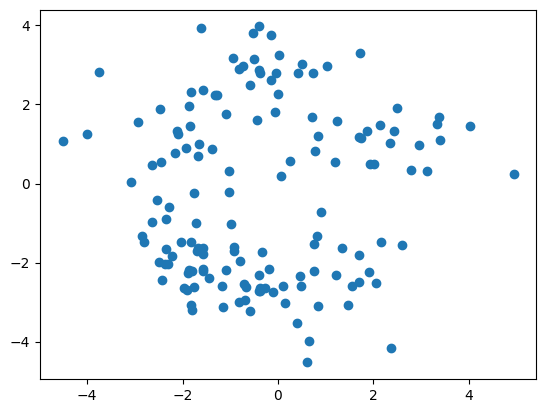

230.49999571591616


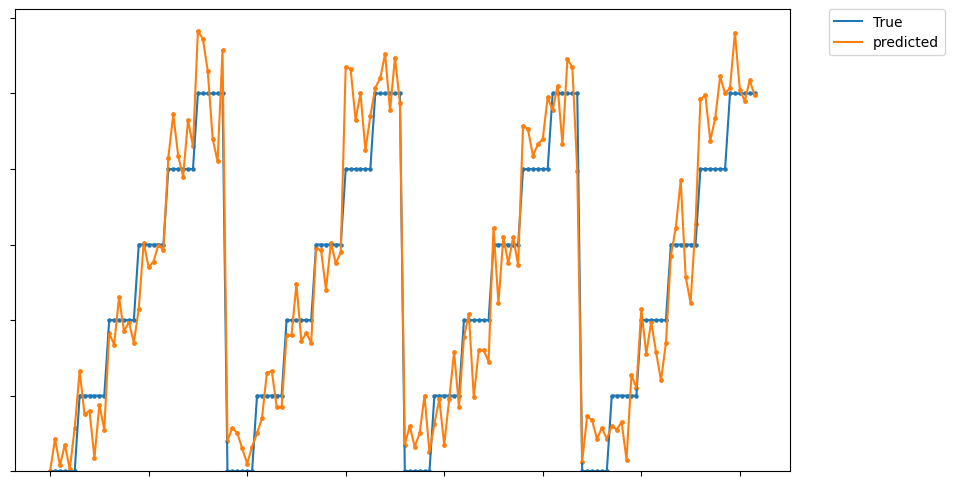

[0.         1.70000005 0.30000001 1.39999998 0.1        2.29999995
 0.60000038 2.89999962 0.70000076 0.39999962 2.60000038 1.20000076
 0.80000019 0.80000019 1.89999962 1.0999999  0.69999981 1.19999981
 1.39999998 2.4000001  1.29999995 2.         4.         1.        ]
[1.70000005 0.30000001 1.39999998 0.1        2.29999995 1.30000019
 2.89999962 0.70000076 0.39999962 2.60000038 1.20000076 3.29999924
 0.80000019 1.89999962 1.0999999  0.69999981 1.19999981 0.19999981
 2.4000001  1.29999995 2.         4.         1.         1.5       ]
[0.30000001 1.39999998 0.1        2.29999995 1.30000019 1.
 0.70000076 0.39999962 2.60000038 1.20000076 3.29999924 2.89999962
 1.89999962 1.0999999  0.69999981 1.19999981 0.19999981 0.30000019
 1.29999995 2.         4.         1.         1.5        0.20000005]
[1.39999998 0.1        2.29999995 1.30000019 1.         0.79999995
 0.39999962 2.60000038 1.20000076 3.29999924 2.89999962 1.20000076
 1.0999999  0.69999981 1.19999981 0.19999981 0.30000019 2.39999962


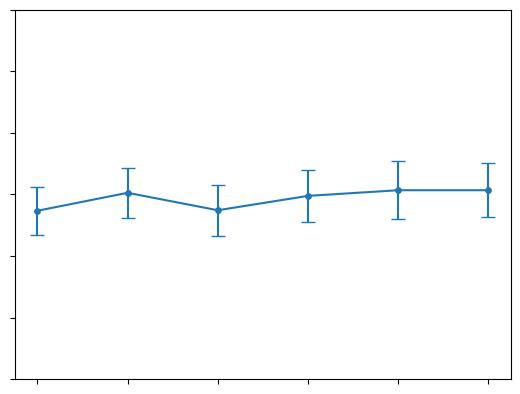

In [10]:
#projection and diffenrence of max index
# df_res = pd.read_csv(file_li[min_in])
df_res = pd.read_csv("/home/gpu_data/data8/cfos_app/timetable/CYCLOPS-2.0-main/results/2024-08-16T06_38_00_eigen_max_9_seed_max_CV_0_8_seed_min_CV_0_15_seed_mth_Gene_400/Fits/Fit_Output_2024-08-16T06_38_00.csv")

plt.scatter(df_res["ProjectionX"], df_res["ProjectionY"])
plt.savefig(figdir + "cyclpus_projection.SVG")
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.show()

mc_ph = df_res["Phases_AG"]-np.pi
predicted = list(map(rad2ph, mc_ph))
score, min_diff = calc_score(sample_names+sample_names, predicted)
diff_mean = diff_plot(min_diff)


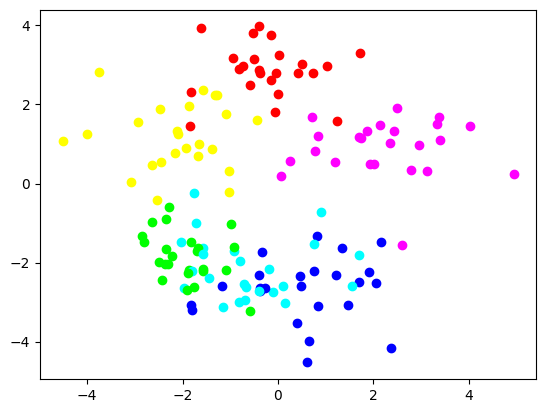

In [49]:
#projection annotation color
from matplotlib.colors import Normalize, LinearSegmentedColormap, BoundaryNorm, ListedColormap, hsv_to_rgb
# CT_li = 

x = df_res["ProjectionX"]
y = df_res["ProjectionY"]


CT_li = np.array([int(i.split("_")[0][2:]) for i in df_res["ID"].tolist()])
ph_li = CT_li%24
ph_li = ph_li/24
ph_li = 1-ph_li
ph_li = [(hue + 1/3 - 1) if (hue + 1/3) > 1 else (hue + 1/3) for hue in ph_li]

for i in range(len(df_res)):

    
    plt.scatter(df_res.iloc[i]["ProjectionX"], df_res.iloc[i]["ProjectionY"],color = hsv_to_rgb([ph_li[i], 1, 1]))
    
#     if i%6==0 and i<72:
#         plt.text(df.iloc[i]["ProjectionX"], df.iloc[i]["ProjectionY"], df.iloc[i]["ID"], fontsize=9, ha='right')
    # plt.xlim(-8, 8)
    # plt.ylim(-8, 8)
plt.savefig(figdir + "cyclpus_projection_annot_color.SVG")
plt.show()

In [21]:
#limit seed genes
min_CV = 0.15
max_CV = 0.8
mth_region = 400

mi = CT_df.iloc[:, 9:].mean(axis=1)
max_order_ind = np.argsort(mi)[::-1].tolist()
CT_df_o = CT_df.iloc[max_order_ind]
CT_df_o = CT_df_o.iloc[0:mth_region]
# seed_regions = array

In [23]:
cv_df = CT_df_o.iloc[:, 9:].std(axis=1)/ CT_df_o.iloc[:, 9:].mean(axis=1)
# cv_df.reset_index(drop=True, inplace=True)
ind =  np.where((np.array(cv_df)<=max_CV)&(np.array(cv_df)>=min_CV))
ind

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        174, 175, 176, 177, 178, 179, 180, 181, 182

In [90]:
df_all = np.array(CT_df_o.iloc[:, 9:])
df_i = (df_all-np.mean(df_all, axis=1).reshape(-1,1))/(np.mean(df_all, axis=1).reshape(-1,1))
df_i

array([[ 1.95373286e-01,  2.64487959e-01,  2.14293387e-01, ...,
        -3.29321194e-01,  2.65740338e-01,  1.68821707e-01],
       [ 1.77188103e-01, -9.47857722e-02,  3.10432847e-02, ...,
         1.35106099e-01, -6.69886943e-02, -6.95578099e-02],
       [-4.54832651e-02, -1.51343118e-02,  6.89191807e-03, ...,
         4.84128943e-01, -1.03673074e-02, -8.59326047e-03],
       ...,
       [-4.94225517e-01, -5.50151414e-01, -6.28817782e-01, ...,
        -1.07110694e-01, -5.96119225e-04,  3.70029072e-02],
       [-6.66918158e-02, -1.57356523e-01,  6.52731965e-02, ...,
         1.79375427e-01, -3.43624284e-01,  8.79647342e-02],
       [ 2.11592838e-01, -2.32925665e-01,  2.02876457e-01, ...,
         7.94127614e-01,  5.72982637e-01,  8.68313339e-01]])

(array([ 61., 107.,  51.,  29.,  10.,   5.,   1.,   0.,   0.,   1.]),
 array([0.14085379, 0.23553305, 0.33021231, 0.42489156, 0.51957082,
        0.61425008, 0.70892933, 0.80360859, 0.89828785, 0.99296711,
        1.08764636]),
 <BarContainer object of 10 artists>)

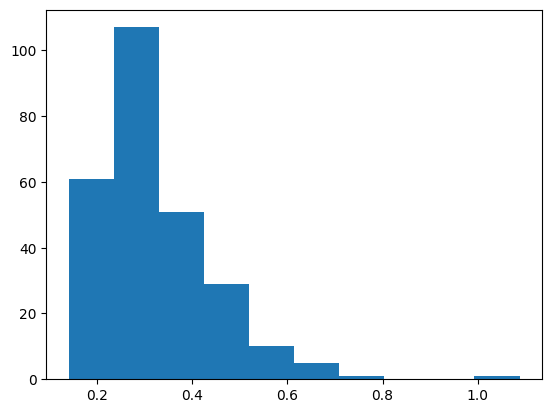

In [92]:
plt.hist(np.std(df_i, axis=1))

[23.2, 23.2, 0.1, 0.1, 0.2, 22.9, 6.1, 2.5, 4.1, 4.8, 3.4, 4.4, 4.0, 3.8, 7.9, 5.2, 8.6, 8.5, 1.7, 10.1, 11.5, 14.1, 12.1, 12.3, 16.2, 19.4, 16.3, 14.5, 17.8, 15.8, 22.6, 23.3, 19.6, 15.2, 16.4, 23.4, 23.4, 21.9, 22.4, 22.9, 1.2, 0.6, 3.8, 1.8, 4.7, 4.4, 5.1, 0.4, 6.6, 2.5, 3.6, 5.7, 7.4, 6.3, 16.1, 1.1, 2.7, 14.0, 14.2, 12.1, 21.7, 21.1, 19.8, 18.9, 18.4, 16.8, 19.6, 21.6, 22.2, 16.3, 22.5, 20.3, 23.3, 20.5, 23.9, 22.0, 20.5, 21.2, 4.3, 3.7, 2.3, 4.0, 6.6, 11.0, 8.2, 7.8, 2.8, 4.7, 6.8, 7.7, 13.6, 6.3, 14.6, 12.1, 14.8, 12.8, 16.4, 20.0, 16.2, 16.3, 17.1, 17.3, 19.3, 17.7, 15.1, 17.8, 19.3, 14.1, 23.6, 23.2, 20.1, 20.6, 20.9, 20.5, 0.9, 8.1, 2.6, 4.9, 4.6, 6.1, 7.6, 7.0, 8.6, 5.9, 5.7, 7.0, 12.8, 13.3, 15.5, 14.5, 14.0, 13.3, 19.6, 17.1, 16.5, 17.2, 19.3, 16.5, 20.9, 16.3, 16.1, 15.8, 19.2, 17.0]
298.09999979287386


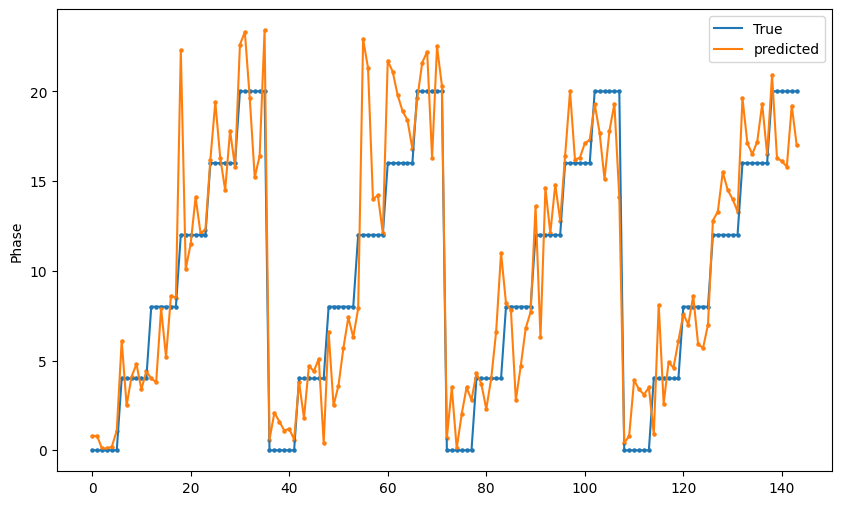

[0.80000001 0.80000001 0.1        0.1        0.2        1.10000002
 0.20000076 3.39999962 0.29999924 1.5        1.79999924 0.19999981
 1.4000001  5.5        4.4000001  2.30000019 0.5999999  1.69999981
 0.69999999 3.5        0.1        2.         3.5        2.79999995]
[0.80000001 0.1        0.1        0.2        1.10000002 2.0999999
 3.39999962 0.29999924 1.5        1.79999924 0.19999981 2.60000038
 5.5        4.4000001  2.30000019 0.5999999  1.69999981 4.0999999
 3.5        0.1        2.         3.5        2.79999995 0.30000019]
[ 0.1         0.1         0.2         1.10000002  2.0999999   1.5
  0.29999924  1.5         1.79999924  0.19999981  2.60000038  3.29999924
  4.4000001   2.30000019  0.5999999   1.69999981  4.0999999  10.89999962
  0.1         2.          3.5         2.79999995  0.30000019  0.29999995]
[ 0.1         0.2         1.10000002  2.0999999   1.5         0.0999999
  1.5         1.79999924  0.19999981  2.60000038  3.29999924  0.39999962
  2.30000019  0.5999999   1.69999

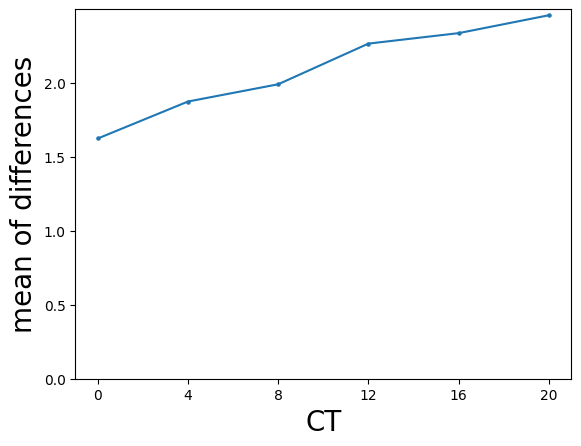

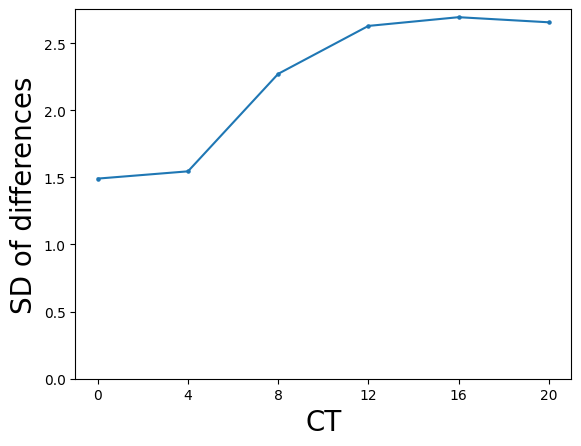

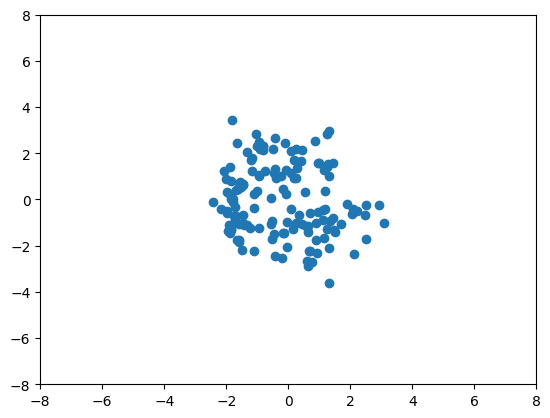

In [7]:
mc_ph = df["Phases_AG"]-np.pi
predicted = list(map(rad2ph, mc_ph))
print(predicted)

score, min_diff = calc_score(sample_names+sample_names, predicted)
diff_plot(min_diff)

plt.scatter(df["ProjectionX"], df["ProjectionY"])
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

In [11]:
sample =  str(df.iloc[i]["ID"])
CT = sample.split("_")[0][2:]
print(CT)

92


In [ ]:
#automatic parameter search
import datetime
res_fol = "/home/gpu_data/data8/cfos_app/timetable/CYCLOPS-2.0-main/results/"
eigen_max_d = "5"
mincv_d = "0_14_"
maxcv_d = "0_9_"
# 基準となる日時
reference_date_str = "2024-06-14T10_30_00"
reference_date = datetime.datetime.strptime(reference_date_str, "%Y-%m-%dT%H_%M_%S")

files = os.listdir(res_fol)


eigen_maxs = []
min_cvs = []
max_cvs = []
scores=[]
diff_mean_li = []
for i, text in enumerate(files):
#     if i>0:
#         continue
        
    try:
        date_str = ("_").join(text.split('_')[0:3])  # 日付部分を抽出
#         print(date_str)
        date_ex = datetime.datetime.strptime(date_str, "%Y-%m-%dT%H_%M_%S")
    except ValueError:
        traceback.print_exc()
    
    
    if date_ex >= reference_date:

        # eigen_max_の後ろの数字を抽出
        eigen_max_match = re.search(r'eigen_max_(\d+)', text)
        if eigen_max_match:
            eigen_max_value = eigen_max_match.group(1)
        else:
            eigen_max_value =  eigen_max_d

        # seed_max_CV_の後ろの数字を抽出
        seed_max_cv_match = re.search(r'seed_max_CV_([\d_]+)', text)
        if seed_max_cv_match:
            seed_max_cv_value = seed_max_cv_match.group(1)
        else:
            seed_max_cv_value = maxcv_d
            
        # seed_min_CV_の後ろの数字を抽出
        seed_min_cv_match = re.search(r'seed_min_CV_([\d_]+)', text)
        if seed_min_cv_match:
            seed_min_cv_value = seed_min_cv_match.group(1)
        else:
            seed_min_cv_value = mincv_d

        # 結果を出力
        print(f'eigen_max_value: {eigen_max_value}')
        print(f'seed_max_cv_value: {seed_max_cv_value}')
        print(f'seed_min_cv_value: {seed_min_cv_value}')
        
        eigen_maxs.append(int(eigen_max_value))
        max_cvs.append(float(seed_max_cv_value.replace('_', '.').rstrip('.')))
        min_cvs.append(float(seed_min_cv_value.replace('_', '.').rstrip('.')))
        
        file_path = res_fol + text + "/Fits/"
        for n, f in enumerate(os.listdir(file_path)):
            if not "Fit_Output" in f:
                continue
                              
            path = file_path + f
            
        df = pd.read_csv(path, index_col =0)
        mc_ph = df["Phases_AG"]-np.pi
        predicted = list(map(rad2ph, mc_ph))
        
        score, min_diff =calc_score(sample_names+sample_names, predicted)
        scores.append(score)
        diff_mean = diff_plot(min_diff)
        diff_mean_li.append(diff_mean)
    
print("max", np.min(scores))
minin = np.argmin(scores)       
min_eigen_max = eigen_maxs[minin]                
min_max_cv = max_cvs[minin] 
min_min_cv = min_cvs[minin] 
print("min_max_cv", min_max_cv)   
print("min_min_cv", min_min_cv) 
print("min_eigen_max", min_eigen_max)   

In [ ]:
#automatic parameter search  regions
import datetime
res_fol = "/home/gpu_data/data8/cfos_app/timetable/CYCLOPS-2.0-main/results/"
min_region_d = 3
eigen_max_d = "99"
mincv_d = "0_85_"
maxcv_d = "0_1_"

num_up = 650
num_low = 100
eigen_up = 15 
eigen_low = 4
mincv_up = 0.45
mincv_low = 0.05
maxcv_up = 0.9
maxcv_low = 0.5


max_cv_i = 0.8
min_cv_i = 0.15
# eigen_max_i =9
num_r_i = 400
# 基準となる日時
reference_date_str = "2024-08-01T15_00_00"
reference_date = datetime.datetime.strptime(reference_date_str, "%Y-%m-%dT%H_%M_%S")

files = os.listdir(res_fol)


eigen_maxs = []
min_cvs = []
max_cvs = []
num_rs = []
scores=[]
diff_mean_li = []

for i, text in enumerate(files):
#     if i>0:
#         continue
        
    try:
        date_str = ("_").join(text.split('_')[0:3])  # 日付部分を抽出
#         print(date_str)
        date_ex = datetime.datetime.strptime(date_str, "%Y-%m-%dT%H_%M_%S")
    except ValueError:
        traceback.print_exc()
    
    
    if date_ex >= reference_date:
        
        # seed_min_CV_の後ろの数字を抽出
        seed_min_cv_match = re.search(r'seed_min_CV_([\d_]+)', text)
        if seed_min_cv_match:
            seed_min_cv_value = seed_min_cv_match.group(1)
        else:
            seed_min_cv_value = mincv_d

        # eigen_max_の後ろの数字を抽出
        eigen_max_match = re.search(r'eigen_max_(\d+)', text)
        if eigen_max_match:
            eigen_max_value = eigen_max_match.group(1)
        else:
            eigen_max_value =  eigen_max_d

        # seed_max_CV_の後ろの数字を抽出
        seed_max_cv_match = re.search(r'seed_max_CV_([\d_]+)', text)
        if seed_max_cv_match:
            seed_max_cv_value = seed_max_cv_match.group(1)
        else:
            seed_max_cv_value = maxcv_d
            
        # seed_mth_Gene_の後ろの数字を抽出
        seed_mth_Gene_match = re.search(r'seed_mth_Gene_([\d_]+)', text)
        if seed_mth_Gene_match:
            seed_mth_Gene_value = seed_mth_Gene_match.group(1)
        else:
            seed_mth_Gene_value = mincv_d

        # 結果を出力
        print(f'eigen_max_value: {eigen_max_value}')
        print(f'seed_max_cv_value: {seed_max_cv_value}')
        print(f'seed_min_cv_value: {seed_min_cv_value}')
        print(f'seed_mth_Gene_value: {seed_mth_Gene_value}')
        
        

        if round(float(seed_max_cv_value.replace('_', '.').rstrip('.')), 2) > maxcv_up:
            continue
        if round(float(seed_max_cv_value.replace('_', '.').rstrip('.')), 2) < maxcv_low:
            continue
        if round(float(seed_min_cv_value.replace('_', '.').rstrip('.')), 2) > mincv_up:
            continue
        if round(float(seed_min_cv_value.replace('_', '.').rstrip('.')), 2) < mincv_low:
            continue
        if int(eigen_max_value) > eigen_up:
            continue
        if int(eigen_max_value) < eigen_low:
            continue
        if int(seed_mth_Gene_value) > num_up:
            continue
        if int(seed_mth_Gene_value) < num_low:
            continue

#         if eigen_max_i !=int(eigen_max_value):
#             continue
        if max_cv_i !=round(float(seed_max_cv_value.replace('_', '.').rstrip('.')), 2):
            continue
        if min_cv_i !=round(float(seed_min_cv_value.replace('_', '.').rstrip('.')), 2):
            continue
        if num_r_i != int(seed_mth_Gene_value):
            continue
        
        eigen_maxs.append(int(eigen_max_value))
        max_cvs.append(float(seed_max_cv_value.replace('_', '.').rstrip('.')))
        min_cvs.append(float(seed_min_cv_value.replace('_', '.').rstrip('.')))
        num_rs.append(int(seed_mth_Gene_value))
        
        file_path = res_fol + text + "/Fits/"
        for n, f in enumerate(os.listdir(file_path)):
            if not "Fit_Output" in f:
                continue
                              
            path = file_path + f
            
        df = pd.read_csv(path, index_col =0)
        mc_ph = df["Phases_AG"]-np.pi
        predicted = list(map(rad2ph, mc_ph))
        
        score, min_diff =calc_score(sample_names+sample_names, predicted)
        diff_mean = diff_plot(min_diff)
        diff_mean_li.append(diff_mean)
        scores.append(score)
                              
print("max", np.min(scores))
minin = np.argmin(scores)       
min_eigen_max = eigen_maxs[minin]                
min_max_cv = max_cvs[minin] 
min_min_cv = min_cvs[minin] 
min_num_r = num_rs[minin] 
print("min_max_cv", min_max_cv)   
print("min_min_cv", min_min_cv) 
print("min_eigen_max", min_eigen_max)
print("min_num_r", min_num_r)

In [15]:
print("max", np.min(scores))
minin = np.argmin(scores)       
min_eigen_max = eigen_maxs[minin]                
min_max_cv = max_cvs[minin] 
min_min_cv = min_cvs[minin] 
print("min_max_cv", min_max_cv)   
print("min_min_cv", min_min_cv) 
print("min_eigen_max", min_eigen_max) 

max 230.49999571591616
min_max_cv 0.8
min_min_cv 0.15
min_eigen_max 9


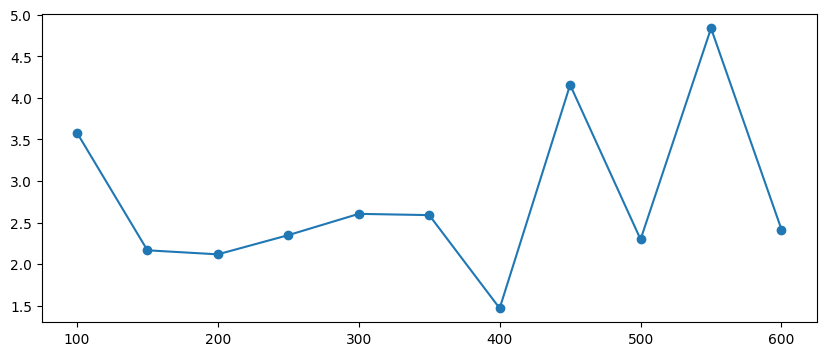

In [8]:
#
# sortin = np.argsort(min_cvs)
# diff_mean_sort = np.array(diff_mean_li)[sortin]
# min_cvs_sort = np.array(min_cvs)[sortin]

# plt.figure(figsize = (20,4))
# plt.plot(min_cvs_sort, diff_mean_sort)
# plt.show()

#
# sortin = np.argsort(eigen_maxs)
# diff_mean_sort = np.array(diff_mean_li)[sortin]
# eigen_maxs_sort = np.array(eigen_maxs)[sortin]

# plt.figure(figsize = (20,4))
# plt.plot(min_cvs_sort, diff_mean_sort)
# plt.show()



sortin = np.argsort(num_rs)
diff_mean_sort = np.array(diff_mean_li)[sortin]
num_rs_sort = np.array(num_rs)[sortin]
# eigen_maxs_sort = np.array(eigen_maxs)[sortin]
# min_cvs_sort = np.array(min_cvs)[sortin]
# max_cvs_sort = np.array(max_cvs)[sortin]


plt.figure(figsize = (10,4))
plt.plot(num_rs_sort, diff_mean_sort)
plt.scatter(num_rs_sort, diff_mean_sort)
plt.savefig("cyclops_min_diff_eigenmax{}_mincv{}_maxcv{}.SVG".format(eigen_max_i, min_cv_i, max_cv_i))
# plt.xlim(,260)
plt.show()

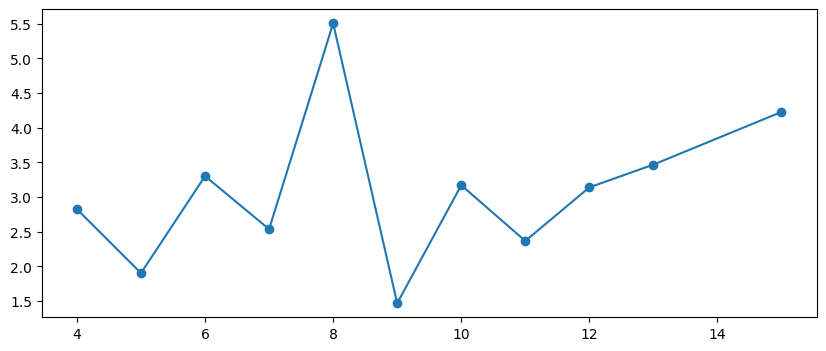

In [11]:
sortin = np.argsort(eigen_maxs)
diff_mean_sort = np.array(diff_mean_li)[sortin]
eigen_maxs_sort = np.array(eigen_maxs)[sortin]

plt.figure(figsize = (10,4))
plt.plot(eigen_maxs_sort, diff_mean_sort)
plt.scatter(eigen_maxs_sort, diff_mean_sort)

plt.savefig("cyclops_min_diff_num{}_mincv{}_maxcv{}.SVG".format(num_r_i, min_cv_i, max_cv_i))
# plt.xlim(,260)
plt.show()

In [ ]:
import datetime
src = "/home/gpu_data/"
j_dir = src + "data8/cfos_app/timetable/CYCLOPS-2.0-main/"
results_pre_fol= j_dir + "results/" 

min_region_d = 197
eigen_max_d = "5"
mincv_d = "0_14_"
maxcv_d = "0_9_"

reference_date_str = "2024-06-17T15_00_00"
reference_date = datetime.datetime.strptime(reference_date_str, "%Y-%m-%dT%H_%M_%S")

files = os.listdir(results_pre_fol)


param_sets = []


for i, text in enumerate(files):
#     if i>0:
#         continue
        
    try:
        date_str = ("_").join(text.split('_')[0:3])  # 日付部分を抽出
#         print(date_str)
        date_ex = datetime.datetime.strptime(date_str, "%Y-%m-%dT%H_%M_%S")
    except ValueError:
        traceback.print_exc()
    
    
    if date_ex >= reference_date:
        
        # seed_min_CV_の後ろの数字を抽出
        seed_min_cv_match = re.search(r'seed_min_CV_([\d_]+)', text)
        if seed_min_cv_match:
            seed_min_cv_value = seed_min_cv_match.group(1)
        else:
            seed_min_cv_value = mincv_d

        # eigen_max_の後ろの数字を抽出
        eigen_max_match = re.search(r'eigen_max_(\d+)', text)
        if eigen_max_match:
            eigen_max_value = eigen_max_match.group(1)
        else:
            eigen_max_value =  eigen_max_d

        # seed_max_CV_の後ろの数字を抽出
        seed_max_cv_match = re.search(r'seed_max_CV_([\d_]+)', text)
        if seed_max_cv_match:
            seed_max_cv_value = seed_max_cv_match.group(1)
        else:
            seed_max_cv_value = maxcv_d
            
        # seed_mth_Gene_の後ろの数字を抽出
        seed_mth_Gene_match = re.search(r'seed_mth_Gene_([\d_]+)', text)
        if seed_mth_Gene_match:
            seed_mth_Gene_value = seed_mth_Gene_match.group(1)
        else:
            seed_mth_Gene_value = mincv_d

        # 結果を出力
        print(f'eigen_max_value: {eigen_max_value}')
        print(f'seed_max_cv_value: {seed_max_cv_value}')
        print(f'seed_min_cv_value: {seed_min_cv_value}')
        print(f'seed_mth_Gene_value: {seed_mth_Gene_value}')
        
        param_sets.append([int(eigen_max_value), float(seed_min_cv_value.replace('_', '.').rstrip('.')), float(seed_max_cv_value.replace('_', '.').rstrip('.')), int(seed_mth_Gene_value)])
        
#         eigen_maxs.append(int(eigen_max_value))
#         max_cvs.append(float(seed_max_cv_value.replace('_', '.').rstrip('.')))
#         min_cvs.append(float(seed_min_cv_value.replace('_', '.').rstrip('.')))
#         num_rs.append(int(seed_mth_Gene_value))

In [11]:

min_regions = [200, 220, 400, 450]
eigen_maxs = np.arange(4,10,1)
model_ns = [80]
min_cvs = [0.05, 0.1]#[0.2]#[0.05, 0.1, 0.2, 0.3]
max_cvs = [0.5]#np.arange(0.5, 1.0, 0.1)#[0.6]#[0.7, 0.8, 0.9, 1.0]
core = 15
#2024-06-18T01_50_00_eigen_max_13_seed_max_CV_0_5_seed_min_CV_0_05_seed_mth_Gene_360




for max_cv in max_cvs:
    for min_cv in min_cvs:
        for min_r in min_regions:
            for eigen_max in eigen_maxs:
                for model_n in model_ns:
                    if [eigen_max, min_cv, max_cv, min_r] in param_sets:
                        print("{}, {}, {}, {} already included".format(eigen_max, min_cv, max_cv, min_r))
                        continue
                    print("{}, {}, {}, {} will be analyzed".format(eigen_max, min_cv, max_cv, min_r))

4, 0.05, 0.5, 200 already included
5, 0.05, 0.5, 200 already included
6, 0.05, 0.5, 200 already included
7, 0.05, 0.5, 200 already included
8, 0.05, 0.5, 200 already included
9, 0.05, 0.5, 200 already included
4, 0.05, 0.5, 220 already included
5, 0.05, 0.5, 220 already included
6, 0.05, 0.5, 220 already included
7, 0.05, 0.5, 220 already included
8, 0.05, 0.5, 220 already included
9, 0.05, 0.5, 220 already included
4, 0.05, 0.5, 400 already included
5, 0.05, 0.5, 400 already included
6, 0.05, 0.5, 400 already included
7, 0.05, 0.5, 400 already included
8, 0.05, 0.5, 400 already included
9, 0.05, 0.5, 400 already included
4, 0.05, 0.5, 450 will be analyzed
5, 0.05, 0.5, 450 will be analyzed
6, 0.05, 0.5, 450 will be analyzed
7, 0.05, 0.5, 450 will be analyzed
8, 0.05, 0.5, 450 will be analyzed
9, 0.05, 0.5, 450 will be analyzed
4, 0.1, 0.5, 200 already included
5, 0.1, 0.5, 200 already included
6, 0.1, 0.5, 200 already included
7, 0.1, 0.5, 200 already included
8, 0.1, 0.5, 200 already

In [46]:
def circular_correlation(theta, phi):
    # Convert angles to radians if they are in degrees
    theta = np.radians(theta)
    phi = np.radians(phi)

    # Mean directions
    theta_bar = np.arctan2(np.sum(np.sin(theta)), np.sum(np.cos(theta)))
    phi_bar = np.arctan2(np.sum(np.sin(phi)), np.sum(np.cos(phi)))

    # Circular correlation
    R_theta_phi = np.mean(np.cos(theta - theta_bar) * np.cos(phi - phi_bar)) + \
                  np.mean(np.sin(theta - theta_bar) * np.sin(phi - phi_bar))

    return R_theta_phi

# Example data
# theta =   # in degrees
phi = df["Phases_AG"]   # in degrees

correlation = circular_correlation(theta, phi)
print(f'Circular correlation: {correlation}')



Circular correlation: 0.9987618001682824
